# Equation of State curve

> [MBx] The following notebook assumes that AiiDA has been installed and a profile has been configured with the required computers/codes. I'll work on a solution that uses a temporary profile in the future.

In [4]:
from aiida import orm, engine, load_profile

load_profile()

Profile<uuid='d4e71fa40fc149edaa183646025f15c1' name='dev'>

## Importing a structure

In [5]:
from pymatgen.core import Structure

structure = orm.StructureData(
    pymatgen_structure=Structure.from_file("../Si.cif")
)

## Relaxing the geometry

In [7]:
from aiida_quantumespresso.workflows.pw.relax import PwRelaxWorkChain
from aiida_quantumespresso.common.types import RelaxType

results = engine.run(PwRelaxWorkChain.get_builder_from_protocol(
    code=orm.load_code('qe-7.2-pw@localhost'),
    structure=structure,
    relax_type=RelaxType.POSITIONS
))

11/19/2023 11:05:58 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4158|PwRelaxWorkChain|setup]: No change in volume possible for the provided base input parameters. Meta convergence is turned off.
11/19/2023 11:05:58 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4158|PwRelaxWorkChain|run_relax]: launching PwBaseWorkChain<4161>
11/19/2023 11:05:59 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4161|PwBaseWorkChain|run_process]: launching PwCalculation<4166> iteration #1
11/19/2023 11:05:59 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4161|PwBaseWorkChain|results]: work chain completed after 1 iterations
11/19/2023 11:06:00 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4161|PwBaseWorkChain|on_terminated]: remote folders will not be cleaned
11/19/2023 11:06:00 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode

In [8]:
relaxed_structure = results['output_structure']

## Calc function to rescale structures

The `calcfunction` below takes an input structure and rescales it to different volumes.

In [9]:
@engine.calcfunction
def rescale_list(structure: orm.StructureData, factor_list: orm.List):

    scaled_structure_dict = {}

    for index, scaling_factor in enumerate(factor_list.get_list()):

        ase_structure = structure.get_ase()

        new_cell = ase_structure.get_cell() * scaling_factor
        ase_structure.set_cell(new_cell, scale_atoms=True)

        scaled_structure_dict[f'structure_{index}'] = orm.StructureData(ase=ase_structure)

    return scaled_structure_dict

Typically, you'd just run it by calling the function as you would a regular Python function:

In [10]:
rescaled_structures = rescale_list(relaxed_structure, orm.List(list=[0.9, 0.95, 1.0, 1.05, 1.1]))

In [11]:
rescaled_structures

{'structure_0': <StructureData: uuid: c61f9f7c-9c3c-4a79-963d-d60ff6e972f1 (pk: 4188)>,
 'structure_1': <StructureData: uuid: 7bb67b47-bdd9-4201-be64-d95c0bf9bfa1 (pk: 4189)>,
 'structure_2': <StructureData: uuid: c5a7be64-0c54-4b9c-9871-2ab3ce1f13d6 (pk: 4190)>,
 'structure_3': <StructureData: uuid: e365dbb5-04bd-4743-9022-7e9469b9717f (pk: 4191)>,
 'structure_4': <StructureData: uuid: 6e7e0f2f-7be7-4a18-a52c-9ffb9b678bb8 (pk: 4192)>}

## EOS: Work function version

In [12]:
from aiida_quantumespresso.workflows.pw.base import PwBaseWorkChain

@engine.workfunction
def run_eos_wf(code: orm.Code, structure: orm.StructureData, scale_factors: orm.List):
    """Run an equation of state of a bulk crystal structure for the given element."""

    parameters = {}

    for label, rescaled_structure in rescale_list(structure, scale_factors).items():

        builder = PwBaseWorkChain.get_builder_from_protocol(
            code=code,
            structure=rescaled_structure,
            protocol='fast'
        )
        results = engine.run(builder)
        parameters[label] = results['output_parameters']

    return parameters

In [14]:
results = run_eos_wf(
    code=orm.load_code('qe-7.2-pw@localhost'),
    structure=relaxed_structure,
    scale_factors=[0.9, 0.95, 1.0, 1.05, 1.1]
)

11/19/2023 11:12:43 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4206|PwBaseWorkChain|run_process]: launching PwCalculation<4211> iteration #1
11/19/2023 11:12:48 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4206|PwBaseWorkChain|results]: work chain completed after 1 iterations
11/19/2023 11:12:48 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4206|PwBaseWorkChain|on_terminated]: remote folders will not be cleaned
11/19/2023 11:12:48 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4222|PwBaseWorkChain|run_process]: launching PwCalculation<4227> iteration #1
11/19/2023 11:12:54 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4222|PwBaseWorkChain|results]: work chain completed after 1 iterations
11/19/2023 11:12:54 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4222|PwBaseWorkChain|on_terminated]:

In [15]:
results

{'structure_0': <Dict: uuid: 180b53be-c207-4417-beff-66916927afa0 (pk: 4216)>,
 'structure_1': <Dict: uuid: 3f501453-ff96-4b11-ba5b-c4c864d0cee3 (pk: 4232)>,
 'structure_2': <Dict: uuid: f1e39949-118d-422d-8567-010f7c37952a (pk: 4248)>,
 'structure_3': <Dict: uuid: 2b3da1e3-6579-43bf-af30-6aea72bd8883 (pk: 4264)>,
 'structure_4': <Dict: uuid: fb69d8e0-142f-42d4-8586-2bba388015ee (pk: 4280)>}

In [16]:
volumes = []
energies = []

for result in results.values():
    volumes.append(result['volume'])
    energies.append(result['energy'])

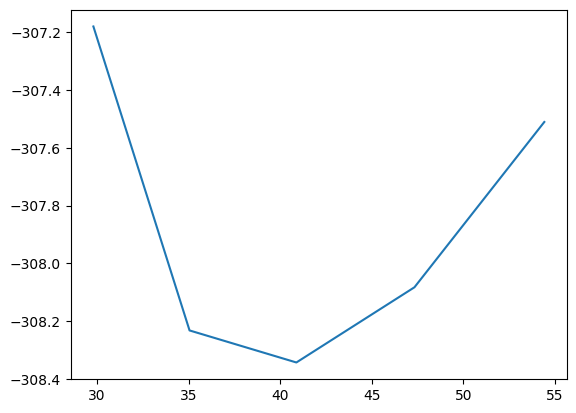

In [17]:
import matplotlib.pyplot as plt

plt.plot(volumes, energies)

In [18]:
@engine.calcfunction
def create_eos_dictionary(**kwargs) -> orm.Dict:
    eos = {
        label: (result['volume'], result['energy'], result['energy_units'])
        for label, result in kwargs.items()
    }
    return orm.Dict(eos)

In [19]:
create_eos_dictionary(**results).get_dict()

{'structure_0': [29.80756462995, -307.18014869427, 'eV'],
 'structure_1': [35.056599073847, -308.2321719355, 'eV'],
 'structure_2': [40.888291673923, -308.34305832306, 'eV'],
 'structure_3': [47.333308649125, -308.08280198495, 'eV'],
 'structure_4': [54.422316216932, -307.51069734205, 'eV']}

## Work chain version

In [20]:
class EquationOfState(engine.WorkChain):
    """WorkChain to compute Equation of State using Quantum ESPRESSO."""

    @classmethod
    def define(cls, spec):
        """Specify inputs and outputs."""
        super().define(spec)
        spec.input("code", valid_type=orm.Code)
        spec.input("structure", valid_type=orm.StructureData)
        spec.input("scale_factors", valid_type=orm.List)

        spec.outline(
            cls.run_eos,
            cls.results,
        )
        spec.output("eos_dict", valid_type=orm.Dict)

    def run_eos(self):

        calcjob_dict = {}

        for label, rescaled_structure in rescale_list(self.inputs.structure, self.inputs.scale_factors).items():

            builder = PwBaseWorkChain.get_builder_from_protocol(
                code=self.inputs.code,
                structure=rescaled_structure,
                protocol='fast'
            )
            calcjob_dict[label] = self.submit(builder)

        self.ctx.labels = list(calcjob_dict.keys())

        # self.to_context(**calcjob_dict)
        return calcjob_dict

    def results(self):

        self.report(self.ctx)

        eos_results = {
            label: self.ctx[label].outputs['output_parameters'] for label in self.ctx.labels
        }
        eos_dict = create_eos_dictionary(**eos_results)
        self.out('eos_dict', eos_dict)


In [21]:
engine.run(EquationOfState, code=orm.load_code('qe-7.2-pw@localhost'),
           structure=relaxed_structure,
           scale_factors=orm.List([0.9, 0.95, 1.0, 1.05, 1.1]))

11/19/2023 11:14:58 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4320|PwBaseWorkChain|run_process]: launching PwCalculation<4333> iteration #1
11/19/2023 11:14:58 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4314|PwBaseWorkChain|run_process]: launching PwCalculation<4341> iteration #1
11/19/2023 11:14:59 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4308|PwBaseWorkChain|run_process]: launching PwCalculation<4349> iteration #1
11/19/2023 11:14:59 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4302|PwBaseWorkChain|run_process]: launching PwCalculation<4357> iteration #1
11/19/2023 11:15:00 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4296|PwBaseWorkChain|run_process]: launching PwCalculation<4365> iteration #1
11/19/2023 11:15:00 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4320|PwBaseWorkC

{'eos_dict': <Dict: uuid: 5fc4c375-14cf-43cf-b760-2ed334e8a2f4 (pk: 4372)>}

In [22]:
builder = EquationOfState.get_builder()

In [23]:
builder.structure = relaxed_structure

In [24]:
builder

Process class: EquationOfState
Inputs:
metadata: {}
structure: Si


In [25]:
builder.scale_factors = orm.List([0.9, 0.95, 1.0, 1.05, 1.1])
builder.code = orm.load_code('qe-7.2-pw@localhost')

In [26]:
results, node = engine.run_get_node(builder)

11/19/2023 11:15:20 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4410|PwBaseWorkChain|run_process]: launching PwCalculation<4423> iteration #1
11/19/2023 11:15:21 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4404|PwBaseWorkChain|run_process]: launching PwCalculation<4431> iteration #1
11/19/2023 11:15:22 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4398|PwBaseWorkChain|run_process]: launching PwCalculation<4439> iteration #1
11/19/2023 11:15:22 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4392|PwBaseWorkChain|run_process]: launching PwCalculation<4447> iteration #1
11/19/2023 11:15:23 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4386|PwBaseWorkChain|run_process]: launching PwCalculation<4455> iteration #1
11/19/2023 11:15:23 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4410|PwBaseWorkC

In [27]:
results['eos_dict'].get_dict()

{'structure_0': [29.80756462995, -307.18014869427, 'eV'],
 'structure_1': [35.056599073847, -308.2321719355, 'eV'],
 'structure_2': [40.888291673923, -308.34305832306, 'eV'],
 'structure_3': [47.333308649125, -308.08280198495, 'eV'],
 'structure_4': [54.422316216932, -307.51069734205, 'eV']}

In [28]:
eos = node.outputs.eos_dict.get_dict()

In [29]:
eos

{'structure_0': [29.80756462995, -307.18014869427, 'eV'],
 'structure_1': [35.056599073847, -308.2321719355, 'eV'],
 'structure_2': [40.888291673923, -308.34305832306, 'eV'],
 'structure_3': [47.333308649125, -308.08280198495, 'eV'],
 'structure_4': [54.422316216932, -307.51069734205, 'eV']}

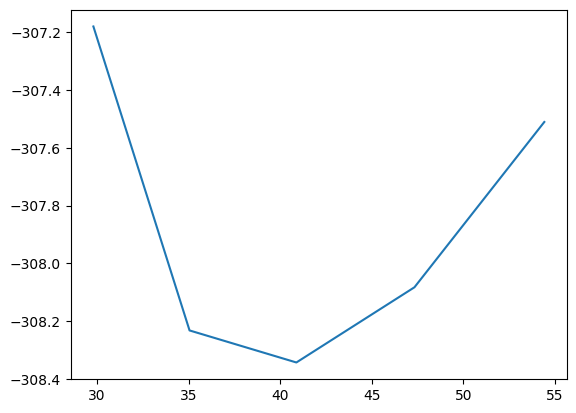

In [30]:
plt.plot(
    [v[0] for v in eos.values()],
    [v[1] for v in eos.values()],
)

## Restarting the work chain

In [31]:
restart_builder = node.get_builder_restart()

In [32]:
restart_builder

Process class: EquationOfState
Inputs:
code: Plane wave Quantum ESPRESSO v7.2 - local compilation
metadata: {}
scale_factors: ''
structure: Si


In [33]:
engine.run(restart_builder)

11/19/2023 11:15:45 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4499|PwBaseWorkChain|run_process]: launching PwCalculation<4512> iteration #1
11/19/2023 11:15:46 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4493|PwBaseWorkChain|run_process]: launching PwCalculation<4520> iteration #1
11/19/2023 11:15:46 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4487|PwBaseWorkChain|run_process]: launching PwCalculation<4528> iteration #1
11/19/2023 11:15:47 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4481|PwBaseWorkChain|run_process]: launching PwCalculation<4536> iteration #1
11/19/2023 11:15:47 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4475|PwBaseWorkChain|run_process]: launching PwCalculation<4544> iteration #1
11/19/2023 11:15:48 AM <38951> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [4499|PwBaseWorkC

{'eos_dict': <Dict: uuid: 0c8b3177-5b77-4dc9-869c-0d178cf938ae (pk: 4551)>}

## Submitting to the daemon

> Note: this requires that the daemon knows where to find the work chain, which means the work chain is stored in a module that is in the `PYTHONPATH`, or (preferably) it is developed in an installed package.

In [36]:
from aiida import engine
from eos_wc import EquationOfState

builder = EquationOfState.get_builder()

builder.structure = relaxed_structure
builder.scale_factors = orm.List([0.9, 0.95, 1.0, 1.05, 1.1])
builder.code = orm.load_code('qe-7.2-pw@localhost')

In [37]:
engine.submit(builder)

<WorkChainNode: uuid: 372a7749-746f-4cf8-b8a4-6e0b33bf71ff (pk: 4553) (eos_wc.EquationOfState)>

The `WorkChain` approach is not very suitable for interactively building a workflow. We've been working on a more flexible variant: the `WorkTree` (I know, we like workflows so much we can't get enough of them):

https://aiida-worktree.readthedocs.io/en/stable/